Tehtävänanto:

Määrittele havainnoista kurssilla oppimasi perusteella seuraavat asiat ja esitä ne numeroina visualisoinnissasi:
- Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta
- Askelmäärä laskettuna kiihtyvyysdatasta Fourier-analyysin perusteella
- Keskinopeus (GPS-datasta)
- Kuljettu matka (GPS-datasta)
- Askelpituus (lasketun askelmäärän ja matkan perusteella)

Esitä ainakin seuraavat kuvaajat:
- Suodatettu kiihtyvyysdata, jota käytit askelmäärän määrittelemiseen.
- Analyysiin valitun kiihtyvyysdatan komponentin tehospektritiheys
- Reittisi kartalla

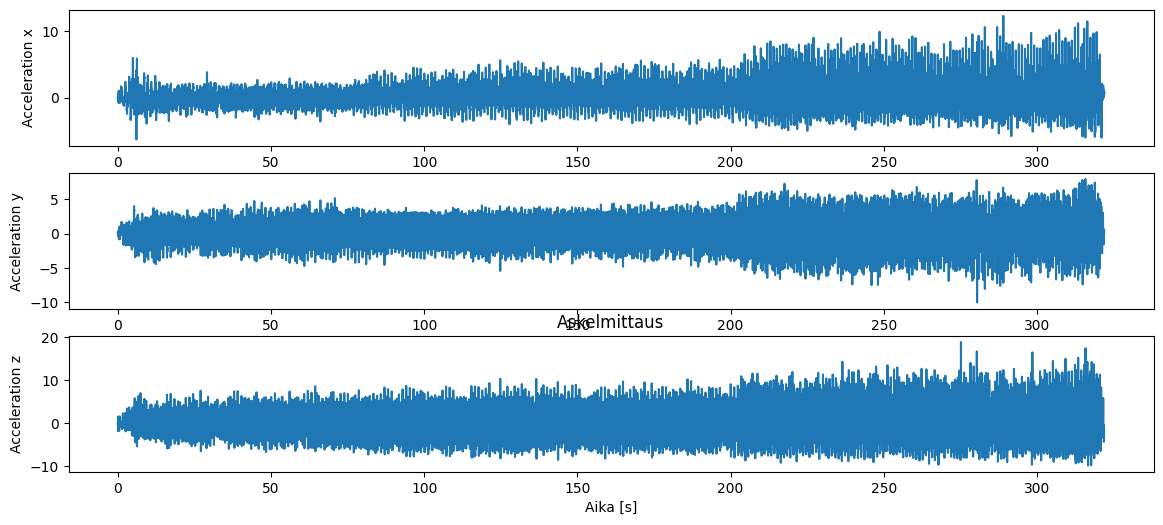

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./Data/Linear Acceleration.csv')
df.head()
plt.figure(figsize=(14,6)) # Määritellään kuvaajan koko
plt.subplot(3,1,1)
plt.plot(df['Time (s)'], df['Linear Acceleration x (m/s^2)'])
plt.ylabel('Acceleration x')
plt.subplot(3,1,2)
plt.plot(df['Time (s)'], df['Linear Acceleration y (m/s^2)'])
plt.ylabel('Acceleration y')
plt.subplot(3,1,3)
plt.plot(df['Time (s)'], df['Linear Acceleration z (m/s^2)'])
plt.ylabel('Acceleration z')

plt.title('Askelmittaus')
plt.xlabel('Aika [s]')
plt.show()

#Datan y-komponentissa on nähtävästi yksi täysi jakso askelta kohden
#Käytetään analyysissä y-komponenttia

In [157]:
# Alustetaan Datan suodatus:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data,cutoff,nyq,order):
    normal_cutoff = cutoff/nyq
    #Get the filter coefficents
    b,a=butter(order,normal_cutoff,btype='low', analog=False)
    y=filtfilt(b,a,data)
    return y

def butter_highpass_filter(data,cutoff,nyq,order):
    normal_cutoff = cutoff/nyq
    b,a = butter(order,normal_cutoff,btype='high',analog=False)
    y=filtfilt(b,a,data)
    return y

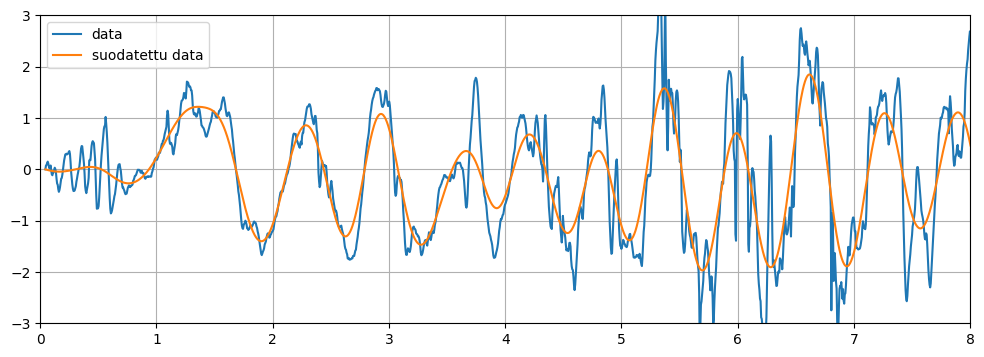

Askelten määrä on 569.0


In [158]:
#Data suodatetaan alipäästösuodattimella. Käytännössä alipäästösuodatin vastaa jossain määrin liukuvaa keskiarvoa.

data=df['Linear Acceleration y (m/s^2)']
T_tot = df['Time (s)'].max() #Koko datan pituus
n=len(df['Time (s)']) # Datapisteiden lukumäärä
fs = n/T_tot # Näytteenottotaajuus
nyq = fs/2 # Nyqvistin taajuus
order=3 # Filtterin kertaluku, suodattimen ominaisuus

#Cut-off taajuus, tätä suuremmat taajuudet alipäästösuodatin poistaa datasta.
# Normaali kävely: 10 sekunnissa 16 askelta --> 1.6 Hz
# Reipas kävely: 10 sekunnissa 19 askelta --> 1.9 Hz
# Valitaan cutoff-taajuus hieman korkeammalta, mutta kuitenkin tarpeeksi matalalta, että data suodattuu. 
cutoff = 2

data_filt = butter_lowpass_filter(data,cutoff,nyq,order)

#Piirretään kuvaaja, jossa alkuperäinen ja suodatettu signaali
plt.figure(figsize=(12,4))
plt.plot(df['Time (s)'], data,label='data')
plt.plot(df['Time (s)'],data_filt,label='suodatettu data')
plt.axis([0,8,-3,3])
plt.grid()
plt.legend()
plt.show()

#Lasketaan askelet
#Tutkitaan, kuinka usein suodatettu signaali ylittää nollatason
jaksot = 0 #jaksot muuttuja lähtee nollasta
for i in range(n-1):
    if data_filt[i]/data_filt[i+1] < 0: #True jos peräkkäisillä arvoilla (data_filt[i] ja data_filt[i+1]) on eri etumerkki, eli nollan ylitys löytyy.
        jaksot = jaksot + 1/2 #aluksi tässä oli vaan yksi, mutta laitettiin puoli, koska nolla ylitetään kaksi kertaa jokaista jaksoa kohti,
print('Askelten määrä on', jaksot)

In [159]:
# Fourier-suodattimet, alustus
# alipäästösuodatin
def alipaasto(data,dt,cutoff):
    N = len(data) # Pisteiden määrä
    fourier = np.fft.fft(data, N) # Fourier-muunnos
    freq = np.fft.fftfreq(N,dt) # Mahdolliset taajuudet
    fourier_clean = fourier.copy() # Kopio alkuperäisen signaalin fft:stä.
    fourier_clean[np.abs(freq) > cutoff] = 0 # Asetetaan nollaan kaikki cut-off taajuutta SUUREMMAT taajuudet.
    # np.abs(freq) ottaa itseisarvon, koska taajuudet on nollan molemmin puolin samanlaiset. tarvitaan negatiiviset mukaan.
    signal_cleaned = np.fft.ifft(fourier_clean) # Palautetaan puhdistettu signaali
    return signal_cleaned.real

# ylipäästösuodatin
def ylipaasto(data, dt, cutoff):
    N = len(data) # Pisteiden määrä
    fourier = np.fft.fft(data, N) # Fourier-muunnos
    freq = np.fft.fftfreq(N,dt) # Mahdolliset taajuudet
    fourier_clean = fourier.copy() # Kopio alkuperäisen signaalin fft:stä.
    fourier_clean[np.abs(freq) < cutoff] = 0 # Asetetaan nollaan kaikki cut-off taajuutta PIENEMMÄT taajuudet!!!
    signal_cleaned = np.fft.ifft(fourier_clean) # Palautetaan puhdistettu signaali
    return signal_cleaned.real

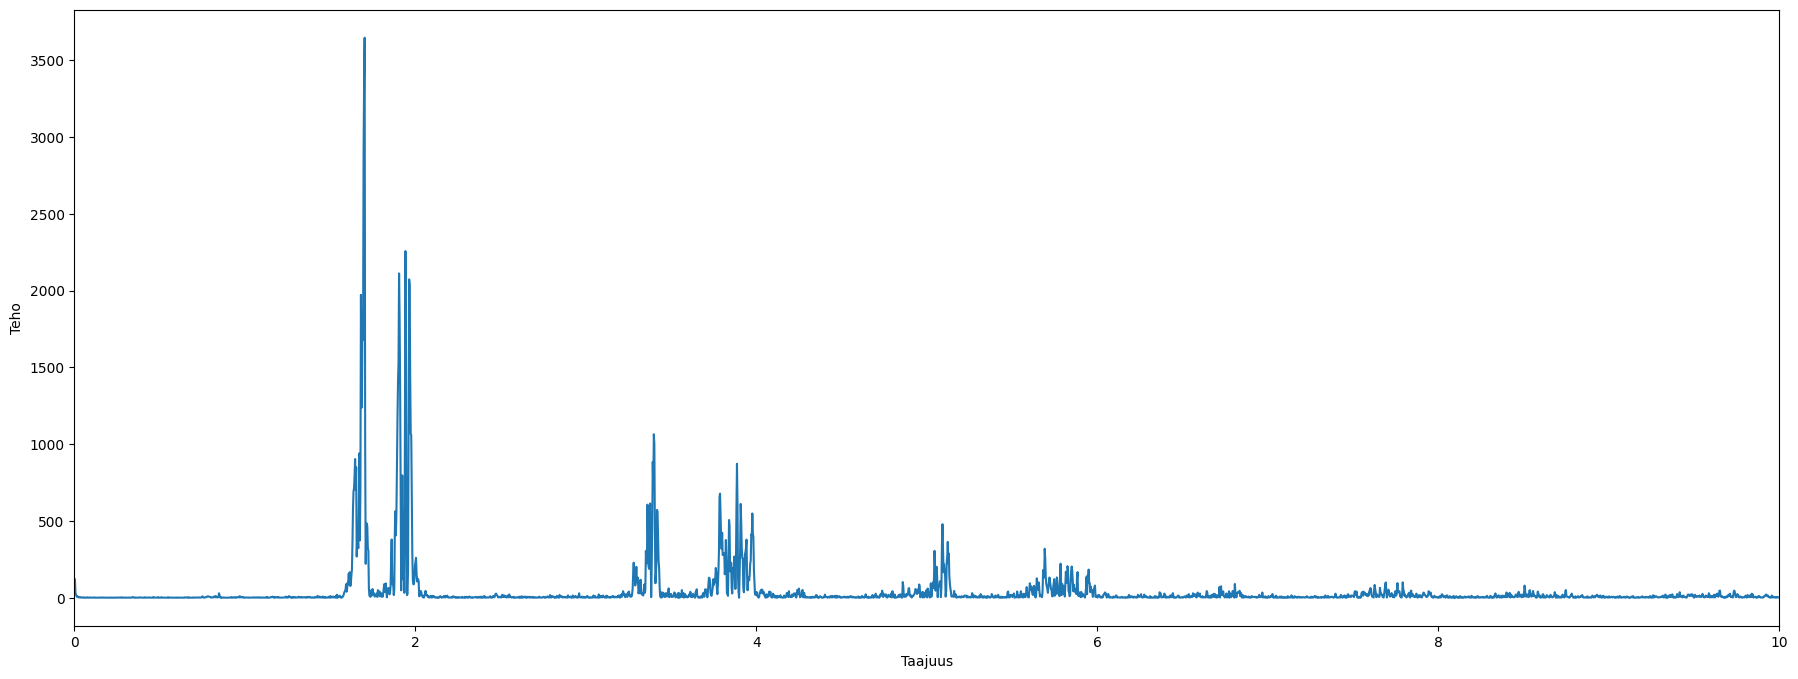

In [160]:
# Tehospektri

data_mean = np.mean(data) # Signaalin keskiarvo
data = data - data_mean # Nollatason poisto

n = len(df['Time (s)']) #Datapisteiden lukumäärä
T_tot = df['Time (s)'].max() #Koko datan pituus (aikasarakkeen viimeinen arvo)
dt = T_tot/n 
fs = 1/dt  # Näytteenottotaajuus
nyq = fs/2
order=3

# Varsinainen tehospektri
# Fourier-muunnos
fourier = np.fft.fft(data, n)
psd = fourier*np.conj(fourier)/n
freq = np.fft.fftfreq(n,dt) 
L = np.arange(1, int(n/2))

plt.figure(figsize=(22,8))
plt.plot(freq[L], psd[L].real) # Laskennallisten numeeristen epätarkkuuksien takia laitetaan .real
plt.xlabel('Taajuus')
plt.ylabel('Teho')
plt.xlim([0,10])
plt.show()
# Kuvaajasta nähdään, että dominoivat piikit ovat juuri ennen 2 Hz, joten 2 Hz cut-off taajuutena on sopiva valinta


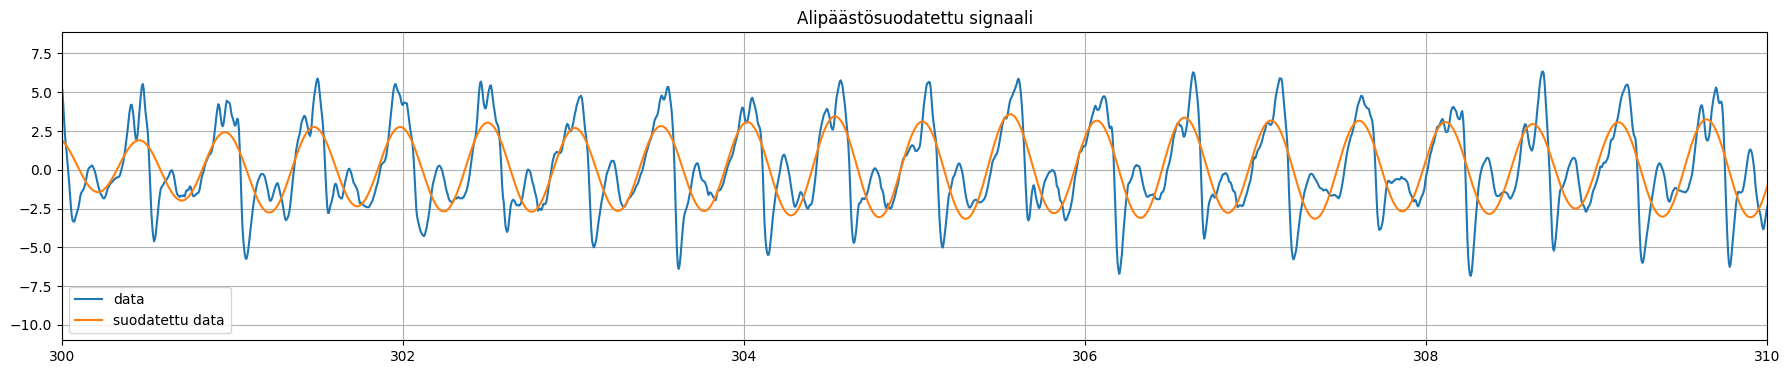

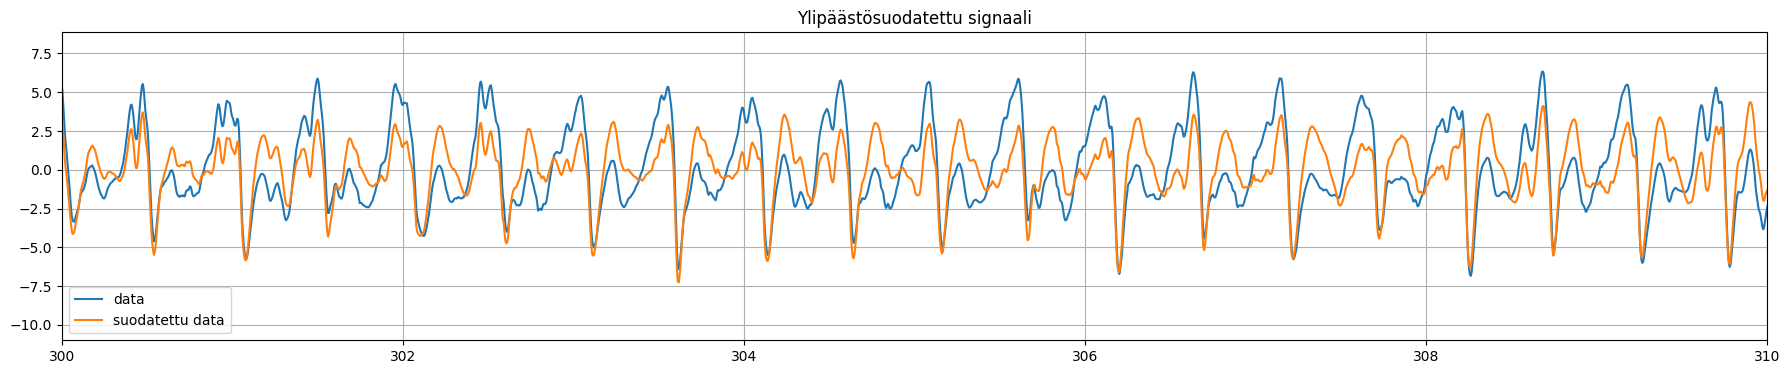

In [161]:

# Käytetään suodattimia datan kanssa

cutoff = 2 # cutoff taajuus, katsottu tehospektristä

data_filt_fft_alipaasto = alipaasto(data,dt,cutoff)
plt.figure(figsize=(22,4))
plt.plot(df['Time (s)'],data,label='data')
plt.plot(df['Time (s)'],data_filt_fft_alipaasto,label='suodatettu data')
plt.title('Alipäästösuodatettu signaali')
plt.grid()
plt.legend()
plt.xlim(300, 310)
plt.show()

data_filt_fft_ylipaasto = ylipaasto(data,dt,cutoff)
plt.figure(figsize=(22,4))
plt.plot(df['Time (s)'],data,label='data')
plt.plot(df['Time (s)'],data_filt_fft_ylipaasto,label='suodatettu data')
plt.title('Ylipäästösuodatettu signaali')
plt.grid()
plt.legend()
plt.xlim(300, 310)
plt.show()


In [162]:
# Lasketaan askeleet Fourier-menetelmän pohjalta

# Askelluksen dominoiva taajuus.
f_max = freq[L][psd[L] == np.max(psd[L])][0] #Kävelymittauksen kiihtyvyyyden y-komponentin tehospektrin suurinta tehoa vastaava taajuus. 
T = 1/f_max # Askeleeseen kuluva aika, eli jaksonaika (oletettaen, että dominoiva taajuus on askeltaajuus)
t = df['Time (s)']
steps = f_max*np.max(t) #Askelmäärä. Voi laskea myös np.max(t)/T

print('Dominoiva askeltaajuus on ',f_max)
print('Tätä vastaava jaksonaika (askelaika) on ', T)
print('Askelmäärä tällöin ', np.round(steps))

Dominoiva askeltaajuus on  1.7022917214751017
Tätä vastaava jaksonaika (askelaika) on  0.5874433784671532
Askelmäärä tällöin  548.0


Seuraava osio:
- keskinopeus
- kuljettu matka
- askelpituus

In [163]:
# Keskinopeus, kuljettu matka, askelpituus
# pandas ja numpy importattu ylempänä

from math import radians,cos,sin,asin,sqrt
import folium as folium

# Lue GPS data
loc = pd.read_csv('./data/Location.csv')
loc.head()


,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,0.000000,65.023815,25.494375,15.631116,NaN,NaN,77.599998,6.476497
1,0.000000,65.019995,25.488749,13.532055,NaN,NaN,55.161999,3.626732
2,3.981706,65.022701,25.493922,0.132678,0.96,239.899994,5.795880,8.492880
3,4.965590,65.022692,25.493903,5.392567,0.97,239.800003,4.162706,5.715352
4,5.967193,65.022694,25.493904,9.923695,1.03,247.899994,3.790092,3.951949


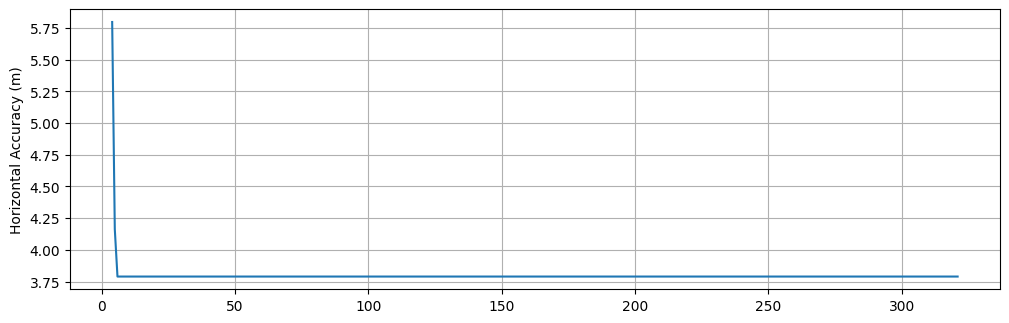

In [164]:
# rajataan pois arvot joilla tarkkuus voi poiketa yli 10m.
loc = loc[loc['Horizontal Accuracy (m)'] <10]
loc = loc.reset_index(drop=True)

# Määritellään karttapohja eli kartan keskipiste
lat1 = loc['Latitude (°)'].mean() #latitudin keskiarvo
long1 = loc['Longitude (°)'].mean() # longituden keskiarvo

# Luodaan kartta
my_map=folium.Map(location=[lat1,long1],zoom_start=17)
# Piirretään reitti kartalle:
folium.PolyLine(loc[['Latitude (°)','Longitude (°)']], color='red', weight=3).add_to(my_map)
my_map.save('Kartta_2026.01.04.html')
my_map

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(loc['Time (s)'], loc['Horizontal Accuracy (m)'])
plt.ylabel('Horizontal Accuracy (m)')
plt.grid()


In [165]:
# Keskinopeus
avg_speed = loc['Velocity (m/s)'].mean()
print(f'Keskinopeus GPS kiihtyvyysdatasta: {avg_speed:.2f} m/s')

Keskinopeus GPS kiihtyvyysdatasta: 1.19 m/s


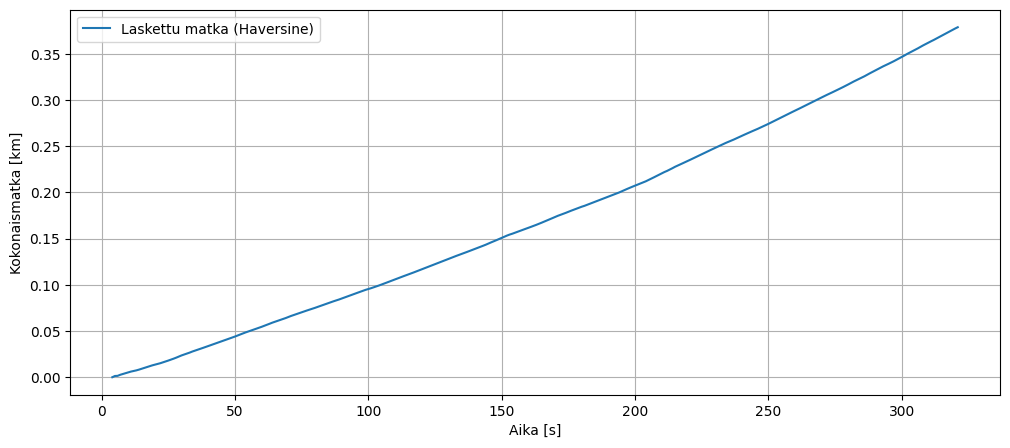

Kuljettu kokonaismatka: 0.379 km


In [166]:
# kuljettu matka käyttäen Haversinen kaavaa.
from math import radians,cos,sin,asin,sqrt
def haversine(lon1,lat1,lon2,lat2):
    lon1,lat1,lon2,lat2 = map(radians, [lon1,lat1,lon2,lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin (dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # radius of earth in km
    return c * r

# Lasketaan kuljettu matka
loc['Distance_calc'] = np.zeros(len(loc))
#Lasketaan välimatka havaintopisteiden välillä käyttäen For luuppia
    #Luuppia ei voi jatkaa ihan loppuun asti, 
    # koska välimatka lasketaan aina arvon ja seuraavan välillä.
    # -1 --> toiseksi viimeiseen arvoon asti lasketaan 
for i in range(len(loc)-1): 
    lon1 = loc['Longitude (°)'][i]
    lon2 = loc['Longitude (°)'][i+1]
    lat1 = loc['Latitude (°)'][i]
    lat2 = loc['Latitude (°)'][i+1]
    loc.loc[i+1, 'Distance_calc'] = haversine(lon1,lat1,lon2,lat2)


#Lasketaan kokonaismatka mittapisteiden välisestä matkasta
loc['total_distance'] = loc['Distance_calc'].cumsum()

plt.figure(figsize=(12,5))
plt.plot(loc['Time (s)'],loc['total_distance'], label='Laskettu matka (Haversine)')
# plt.plot(loc['Time (s)'],loc['Distance (km)'])
plt.ylabel('Kokonaismatka [km]')
plt.xlabel('Aika [s]')
plt.legend()
plt.grid()
plt.show()

# kokonaismatka
total_distance = loc['total_distance'].iloc[-1]
print(f'Kuljettu kokonaismatka: {total_distance:.3f} km')


In [ ]:
# Askelpituus

askelmaara = jaksot
askelpituus = total_distance*1000/askelmaara #km metreiksi
print(f'Askelpituus: {askelpituus:.2f} m')

Askelpituus: 0.67 m
